# 2. EDA and Preprocessing
This notebook performs exploratory data analysis and cleaning on the synthetic sales data.

In [7]:
import pandas as pd, numpy as np
sales = pd.read_csv('../data/synthetic_sales.csv', parse_dates=['date'])
meta = pd.read_csv('../data/sku_metadata.csv')

In [8]:
# Data cleaning
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.sort_values(['sku_id','date']).reset_index(drop=True)
all_dates = pd.date_range(sales['date'].min(), sales['date'].max())
full = []
for sku in sales['sku_id'].unique():
    tmp = sales[sales['sku_id']==sku].set_index('date').reindex(all_dates).rename_axis('date').reset_index()
    tmp['sku_id'] = sku
    tmp['units_sold'] = tmp['units_sold'].fillna(0).astype(int)
    tmp['price'] = tmp['price'].fillna(method='ffill').fillna(0)
    tmp['on_promo'] = tmp['on_promo'].fillna(0).astype(int)
    tmp['views'] = tmp['views'].fillna(0).astype(int)
    full.append(tmp)
sales_full = pd.concat(full, ignore_index=True)
sales_full['units_sold'] = sales_full['units_sold'].clip(lower=0)
sales_full['views'] = sales_full['views'].clip(lower=0)
sales_full['price'] = sales_full['price'].clip(lower=0)

In [9]:
# Per SKU stats
grouped = sales_full.groupby('sku_id')['units_sold']
summary = grouped.agg(['mean','std']).rename(columns={'mean':'mean_daily','std':'std_daily'}).reset_index()
summary['cv'] = summary['std_daily'] / summary['mean_daily']
summary['pct_zero_days'] = sales_full.groupby('sku_id').apply(lambda g: (g['units_sold']==0).mean()*100).values
summary.head(10)

,sku_id,mean_daily,std_daily,cv,pct_zero_days
0,SKU_01,295.965753,81.080767,0.273953,0.000000
1,SKU_02,2.400000,12.313977,5.130824,78.904110
2,SKU_03,49.479452,22.277899,0.450245,0.000000
3,SKU_04,42.886301,19.456736,0.453682,0.000000
4,SKU_05,147.780822,41.521689,0.280968,0.000000
5,SKU_06,58.027397,18.995179,0.327348,0.000000
6,SKU_07,2.539726,11.772031,4.635158,75.753425
7,SKU_08,294.428767,62.928169,0.213730,0.000000
8,SKU_09,205.291781,54.265173,0.264332,0.000000
9,SKU_10,77.279452,30.310171,0.392215,0.000000


In [10]:
# Top 5 SKUs by revenue
price_mean = sales_full.groupby('sku_id')['price'].mean()
units_mean = sales_full.groupby('sku_id')['units_sold'].mean()
revenue = (price_mean * units_mean).sort_values(ascending=False)
revenue.head(5)

sku_id
SKU_01    188831.307787
SKU_08    178639.802427
SKU_17    170251.985120
SKU_16    135838.280647
SKU_09    123861.252052
dtype: float64

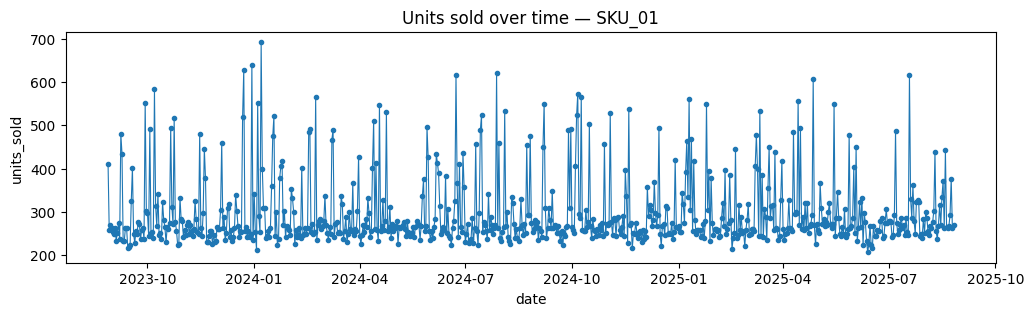

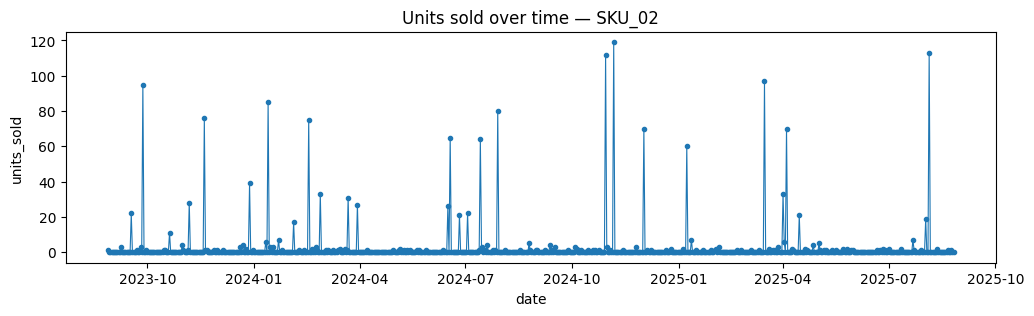

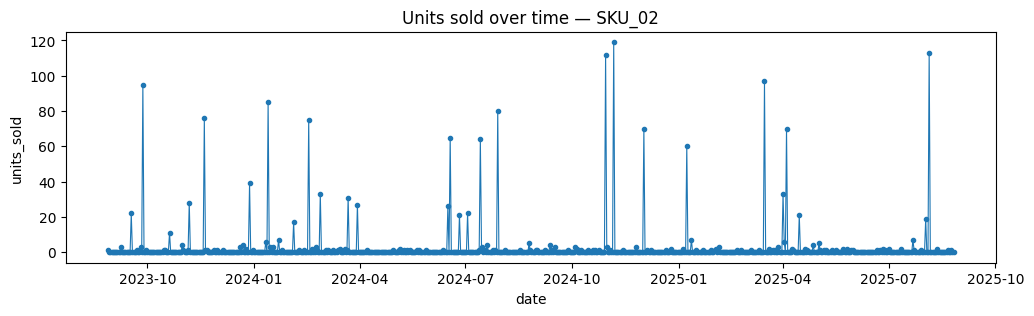

In [11]:
# Visuals: time series plot for 3 sample SKUs
import matplotlib.pyplot as plt
fast_sku = summary.sort_values('mean_daily', ascending=False)['sku_id'].iloc[0]
slow_sku = summary.sort_values('mean_daily', ascending=True)['sku_id'].iloc[0]
int_sku = 'SKU_02'
sample_skus = [fast_sku, slow_sku, int_sku]
for sku in sample_skus:
    df = sales_full[sales_full['sku_id']==sku]
    plt.figure(figsize=(12,3))
    plt.plot(df['date'], df['units_sold'], marker='.', linewidth=0.8)
    plt.title(f'Units sold over time — {sku}')
    plt.xlabel('date'); plt.ylabel('units_sold')
    plt.show()

In [12]:
# Classify SKUs
summary['bucket'] = 'medium'
summary.loc[summary['mean_daily'] >= 50, 'bucket'] = 'fast_mover'
summary.loc[summary['mean_daily'] < 20, 'bucket'] = 'slow_mover'
summary.loc[(summary['pct_zero_days'] > 40) | (summary['cv'] > 1.5), 'bucket'] = 'intermittent'
summary[['sku_id','mean_daily','std_daily','cv','pct_zero_days','bucket']]

,sku_id,mean_daily,std_daily,cv,pct_zero_days,bucket
0,SKU_01,295.965753,81.080767,0.273953,0.000000,fast_mover
1,SKU_02,2.400000,12.313977,5.130824,78.904110,intermittent
2,SKU_03,49.479452,22.277899,0.450245,0.000000,medium
3,SKU_04,42.886301,19.456736,0.453682,0.000000,medium
4,SKU_05,147.780822,41.521689,0.280968,0.000000,fast_mover
5,SKU_06,58.027397,18.995179,0.327348,0.000000,fast_mover
6,SKU_07,2.539726,11.772031,4.635158,75.753425,intermittent
7,SKU_08,294.428767,62.928169,0.213730,0.000000,fast_mover
8,SKU_09,205.291781,54.265173,0.264332,0.000000,fast_mover
9,SKU_10,77.279452,30.310171,0.392215,0.000000,fast_mover
